### Multi-Label Classfication 

After fitting a CNN for binary classification to identify whether a comment is toxic or not toxic, we now fit another CNN which does multi-label classification on our dataset. 

We do this to identify what makes a comment "toxic". The categories we have are "severe_toxic", "obscene", "threat", "insult" and "identity_hate". This model is different from a multi-class classification because the categories are NOT mutually exclusive, that is, a comment can have a value of 1 for both "obscene" and "threat". 


Look at just toxic dataframe?

In [24]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from torchtext.vocab import GloVe
from itertools import combinations
import torch
import os
import time
from sklearn.metrics import classification_report

In [33]:
# Read in balanced dataset 

data_path = '/Users/irsaashraf/Desktop/UChicago/Spring_23/Advanced ML/Project/Irsa_project/balanced_data.csv'
df = pd.read_csv(data_path)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,length,word_count
0,1b7fe21f6b20f176,The Wack Pack \n\nYou're fucking insane and dr...,1,0,1,0,1,0,220,37
1,2b77b61ee27ab6fb,Not according to Wikipedia policy. With respec...,0,0,0,0,0,0,77,11
2,626d12d910b34c40,"You just revert my and a lot of peoples work, ...",1,0,1,0,1,0,222,39
3,2ed8095b9ee464b0,"Frank O'Hara, Anti-Beat? \nSeriously, dude, yo...",0,0,0,0,0,0,544,93
4,86f8607fd0572b9f,"""\n\nreverting\nUser:Baristarim decides that t...",0,0,0,0,0,0,440,72


In [34]:
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
print(len(df))
df[classes].sum()

30588


toxic            15294
severe_toxic      1595
obscene           7987
threat             451
insult            7401
identity_hate     1306
dtype: int64

In [35]:
(df[classes].sum()/len(df)) * 100

toxic            50.000000
severe_toxic      5.214463
obscene          26.111547
threat            1.474434
insult           24.195763
identity_hate     4.269648
dtype: float64

With this dataset, we are again faced with the problem of imbalanced data as threat and identity_hate make up less than 5% of the entire dataset. 
To deal with this, we will only look at the toxic datatset, i.e., the new dataset we will work with will be where toxic == 1.
We will also drop the "severe_toxic" column since it is redundant. So the number of classes after this will be 4, comprised of "obscene", "threat", "insult" and "identity_hate".

In [36]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


### Creating new dataset 

In [37]:
toxic_df = df[df['toxic']==1].reset_index(drop=True)

# drop unnecesary columns 
cols_to_drop = ['toxic', 'severe_toxic']
toxic_df.drop(columns=cols_to_drop, inplace=True)
toxic_df.head()

,id,comment_text,obscene,threat,insult,identity_hate,length,word_count
0,1b7fe21f6b20f176,The Wack Pack \n\nYou're fucking insane and dr...,1,0,1,0,220,37
1,626d12d910b34c40,"You just revert my and a lot of peoples work, ...",1,0,1,0,222,39
2,f92ee22605469bb7,", and it's mean as shit",1,0,1,0,23,6
3,cf542fa3e6580a15,You Are A Complete Idiot \n\nI didn't create t...,1,0,1,0,381,67
4,1c89b445b0d9c009,Waterloo Road Characters WTF!! \n\nWhat the f*...,0,0,0,0,177,28


In [39]:
new_classes = ['obscene', 'threat', 'insult', 'identity_hate']

(toxic_df[new_classes].sum()/len(toxic_df)) * 100

obscene          51.824245
threat            2.935792
insult           48.018831
identity_hate     8.513142
dtype: float64

The dataset for threat and identity_hate is still quite imbalanced. Since we don't want to reduce the size of the dataset anymore, we will use accuracy metrics like hamming_distance and F1 score that are used specifically for imbalanced datasets

In [41]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
print(tf.__version__)

2.11.1


In [43]:
sentences = toxic_df['comment_text'].values
y_classes = toxic_df[new_classes].values
sentences

array(["The Wack Pack \n\nYou're fucking insane and drunk with power. Instead of totally removing big Howard Stern guys like Crackhead Bob and Fred the Elephant Boy, why not just remove the parts that your majesty finds offensive?",
       'Not according to Wikipedia policy. With respect 99.231.50.255  Pavel Golikov.',
       "You just revert my and a lot of peoples work, to improve wiki. So you're a motherfucker. How dare you block an user or users, just because he or she reverted your destructive activite. Shame on you.\nShitface Anna Frodesiak",
       ...,
       'The Criticism section \n\nThe way the criticism section reads at the time of this writing is quite okay, in my opinion. It brings up the most important, on point criticisms of the mainstream in a very readable, well sourced manner, without superfluous ad hominem comments. It also include a reasonable level of Austrian responses to the criticisms. In my view, there is no need for any further changes.\n\nThe Mises-slur is, 

In [44]:
y_classes

array([[1, 0, 1, 0],
       [0, 0, 0, 0],
       [1, 0, 1, 0],
       ...,
       [0, 0, 0, 0],
       [1, 0, 1, 0],
       [1, 0, 0, 0]])

In [50]:
# Create a train, validate and test dataset 
# train 70%, validation 20%, test 10%

X_train, X_rest, y_train, y_rest = train_test_split(sentences, y_classes, test_size=0.3, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.33, random_state=1)

print("train:", len(X_train), "validation:", len(X_val), "test", len(X_test))

train: 21411 validation: 6148 test 3029


In [51]:
# Preprocess the data

NUM_WORDS = 10000

# Using max_len = 200 for consistency 
MAX_LEN = 200

tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train, padding='post', maxlen=MAX_LEN)
X_val = pad_sequences(X_val, padding='post', maxlen=MAX_LEN)
X_test = pad_sequences(X_test, padding='post', maxlen=MAX_LEN)

### Embedding Matrix 

In [52]:
glove = GloVe(name='6B')

In [53]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    
    vocab_size = len(word_index) + 1 
    # Adding 1 because of reserved 0 index
    
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    # Load the pre-trained GloVe embeddings
    embeddings_index = {}
    with open(filepath, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = coefs

    return embedding_matrix

In [54]:
EMBEDDING_DIM = 300
glove_filename = 'glove.6B.300d.txt'
glove_filepath = '/Users/irsaashraf/Desktop/UChicago/Spring_23/Advanced ML/Project/Irsa_project/glove.6B'
glove_filepath_final = os.path.join(glove_filepath, glove_filename)

word_index = tokenizer.word_index
embedding_matrix = create_embedding_matrix(glove_filepath_final, word_index, EMBEDDING_DIM)

In [55]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

In [56]:
# Use keras to define the model architecture of the CNN

FILTERS= 128
KERNEL_SIZE = 5
ACTIVATION='relu'
ACTIVATION_LAST='sigmoid'
VOCAB_SIZE = len(word_index)+1
DROPOUT = 0.5
UNITS_FIRST = 64
UNITS_SECOND = 4


model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, weights=[embedding_matrix],input_length=MAX_LEN, trainable=False))
model.add(Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation=ACTIVATION))
model.add(GlobalMaxPooling1D())
model.add(Dense(units=UNITS_FIRST, activation=ACTIVATION))
model.add(Dropout(DROPOUT))
model.add(Dense(units=UNITS_SECOND, activation=ACTIVATION_LAST))

In [57]:
# Compile the model

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [58]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 300)          16449300  
                                                                 
 conv1d_2 (Conv1D)           (None, 196, 128)          192128    
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 4)                 260       
                                                      

In [59]:
# Train the model
EPOCHS = 50
BATCH_SIZE = 16

start_time = time.time()
history = model.fit(X_train, y_train,
                    epochs=EPOCHS,
                    validation_data=(X_val, y_val),
                    batch_size=BATCH_SIZE)

print(f'Time taken to complete all {EPOCHS} epochs: {time.time() - start_time} seconds')

Epoch 1/50
1339/1339 [==============================] - 30s 23ms/step - loss: 0.2185 - accuracy: 0.5043 - val_loss: 0.1790 - val_accuracy: 0.3930
Epoch 2/50
1339/1339 [==============================] - 29s 21ms/step - loss: 0.1699 - accuracy: 0.4911 - val_loss: 0.1680 - val_accuracy: 0.5151
Epoch 3/50
1339/1339 [==============================] - 28s 21ms/step - loss: 0.1479 - accuracy: 0.4817 - val_loss: 0.1722 - val_accuracy: 0.3362
Epoch 4/50
1339/1339 [==============================] - 28s 21ms/step - loss: 0.1287 - accuracy: 0.4918 - val_loss: 0.1829 - val_accuracy: 0.7010
Epoch 5/50
1339/1339 [==============================] - 28s 21ms/step - loss: 0.1138 - accuracy: 0.5190 - val_loss: 0.1983 - val_accuracy: 0.6191
Epoch 6/50
1339/1339 [==============================] - 30s 23ms/step - loss: 0.0983 - accuracy: 0.5235 - val_loss: 0.2238 - val_accuracy: 0.6981
Epoch 7/50
1339/1339 [==============================] - 29s 22ms/step - loss: 0.0870 - accuracy: 0.5409 - val_loss: 0.2166 -

In [60]:
# Get prediction metrics

# label_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred, target_names = new_classes))

95/95 [==============================] - 2s 16ms/step
               precision    recall  f1-score   support

      obscene       0.82      0.77      0.79       843
       threat       0.73      0.39      0.51        41
       insult       0.71      0.70      0.71       742
identity_hate       0.56      0.35      0.43       126

    micro avg       0.76      0.70      0.73      1752
    macro avg       0.71      0.55      0.61      1752
 weighted avg       0.75      0.70      0.72      1752
  samples avg       0.23      0.23      0.22      1752



/Users/irsaashraf/anaconda3/envs/capp30255/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/irsaashraf/anaconda3/envs/capp30255/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
## SAVE THE MODEL TO DISK ##

model.save("ml_model3_50epochs.h5")
print("Saved model to disk")

Saved model to disk


670/670 [==============================] - 11s 16ms/step - loss: 0.0076 - accuracy: 0.7715
Training Accuracy: 0.7715
Validation Accuracy:  0.7054
Testing Accuracy:  0.7227


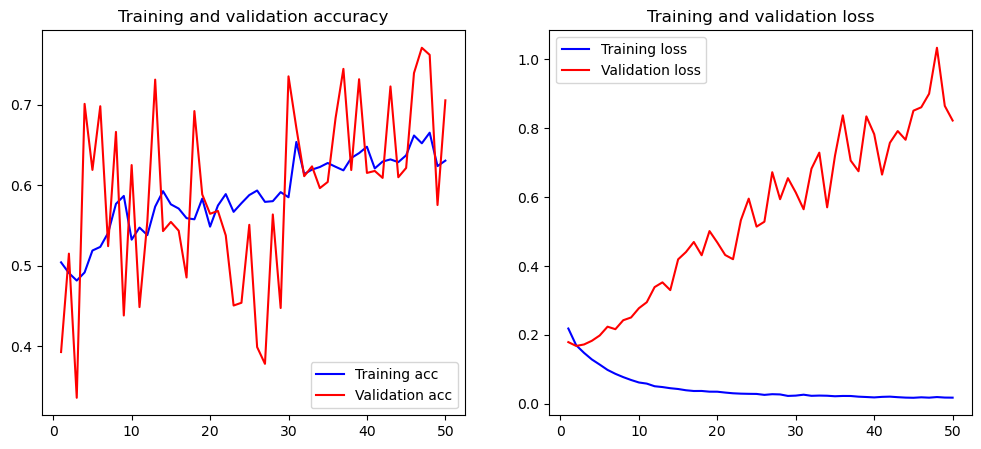

In [61]:
# Plot results 

loss_train, accuracy_train = model.evaluate(X_train, y_train)
print("Training Accuracy: {:.4f}".format(accuracy_train))
loss_val, accuracy_val = model.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy_val))
loss_test, accuracy_test = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy_test))
plot_history(history)

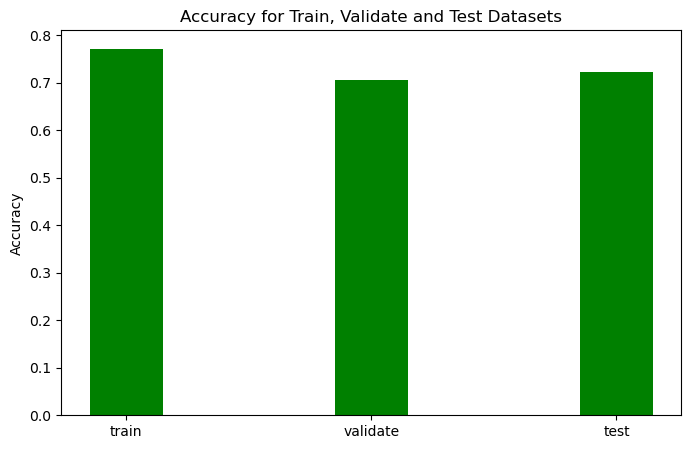

In [62]:
acc_dict = {'train': accuracy_train, 'validate':accuracy_val, 'test':accuracy_test}
x_ = list(acc_dict.keys())
values = list(acc_dict.values())

  
fig = plt.figure(figsize = (8, 5))
 
# creating the bar plot
plt.bar(x_, values, color ='green',
        width = 0.3)
 
# plt.xlabel("Dataset")
plt.ylabel("Accuracy")
plt.title("Accuracy for Train, Validate and Test Datasets")
plt.show()

Training accuracy is the lowest while testing is the highest. Model is not overfitting at all.

In [63]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

## New dataset 

In [65]:
yt_df = pd.read_csv('/Users/irsaashraf/Desktop/UChicago/Spring_23/Advanced ML/Project/Irsa_project/youtoxic_english_1000.csv')
yt_df


,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,If only people would just take a step back and...,False,False,False,False,False,False,False,False,False,False,False,False
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,Law enforcement is not trained to shoot to app...,True,True,False,False,False,False,False,False,False,False,False,False
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,\nDont you reckon them 'black lives matter' ba...,True,True,False,False,True,False,False,False,False,False,False,False
3,Ugg7Gd006w1MPngCoAEC,04kJtp6pVXI,There are a very large number of people who do...,False,False,False,False,False,False,False,False,False,False,False,False
4,Ugg8FfTbbNF8IngCoAEC,04kJtp6pVXI,"The Arab dude is absolutely right, he should h...",False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Ugi5ADt10EdDz3gCoAEC,XRuCW80L9mA,I remember that they sent in the national defe...,False,False,False,False,False,False,False,False,False,False,False,False
996,Ugifh2DMhBbDkHgCoAEC,XRuCW80L9mA,Stats don`t represent the problem. Race baitin...,True,False,False,False,False,True,True,False,False,False,False,False
997,Ugj_plbGBjjzYXgCoAEC,XRuCW80L9mA,The quote from the mother... Wow that hit hard...,False,False,False,False,False,False,False,False,False,False,False,False
998,Ugj0bah1De8xy3gCoAEC,XRuCW80L9mA,this video is so racist,False,False,False,False,False,False,False,False,False,False,False,False


In [76]:
cols_to_keep = ['Text', 'IsToxic', 'IsThreat', 'IsObscene', 'IsReligiousHate', 'IsHomophobic', 'IsSexist', 'IsRacist']
yt_df_new = yt_df[cols_to_keep]
yt_df_new

# Convert to binary 1 and 0
cols_to_convert = ['IsToxic', 'IsThreat', 'IsObscene', 'IsReligiousHate', 'IsHomophobic', 'IsSexist', 'IsRacist']
yt_df_new[cols_to_convert] = yt_df_new[cols_to_convert].astype(int)

# Now create an identity hate column based on the last three columns
cols_to_check = ['IsReligiousHate', 'IsHomophobic', 'IsSexist', 'IsRacist']
yt_df_new['identity_hate'] = (yt_df_new[cols_to_check] == 1).any(axis=1).astype(int)

# Drop the extra columns 
yt_df_new.drop(columns=cols_to_check, inplace=True)

# Change column names 
name_map = {'Text':'comment_text', 'IsToxic':'toxic', 'IsThreat':'threat', 'IsObscene':'obscene'}
yt_df_new.rename(columns=name_map, inplace=True)
yt_df_new

/var/folders/7x/ln_3wt0j7v9dkyhj_b2t6v480000gn/T/ipykernel_19264/175894963.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yt_df_new[cols_to_convert] = yt_df_new[cols_to_convert].astype(int)
/var/folders/7x/ln_3wt0j7v9dkyhj_b2t6v480000gn/T/ipykernel_19264/175894963.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yt_df_new['identity_hate'] = (yt_df_new[cols_to_check] == 1).any(axis=1).astype(int)
/var/folders/7x/ln_3wt0j7v9dkyhj_b2t6v480000gn/T/ipykernel_19264/175894963.py:14: SettingWithCopyWarning

,comment_text,toxic,threat,obscene,identity_hate
0,If only people would just take a step back and...,0,0,0,0
1,Law enforcement is not trained to shoot to app...,1,0,0,0
2,\nDont you reckon them 'black lives matter' ba...,1,0,1,0
3,There are a very large number of people who do...,0,0,0,0
4,"The Arab dude is absolutely right, he should h...",0,0,0,0
...,...,...,...,...,...
995,I remember that they sent in the national defe...,0,0,0,0
996,Stats don`t represent the problem. Race baitin...,1,0,0,1
997,The quote from the mother... Wow that hit hard...,0,0,0,0
998,this video is so racist,0,0,0,0


In [77]:
## Check class percentage 
yt_df_classes = ['toxic', 'threat', 'obscene', 'identity_hate']
(yt_df_new[yt_df_classes].sum()/len(yt_df_new)) * 100

toxic            46.2
threat            2.1
obscene          10.0
identity_hate    13.6
dtype: float64

The dataset seems balanced for toxic comments so it can be at least used as a good test for the binary cassifier

In [78]:
# Save to csv 
path='/Users/irsaashraf/Desktop/UChicago/Spring_23/Advanced ML/Project/Irsa_project'

# yt_df_new.to_csv(os.path.join(path, 'youtube_comments_for_testing.csv'), index=False)

In [68]:
yt_df_new['identity_hate'] = np.where(yt_df_new['IsReligiousHate'])

,Text,IsToxic,IsThreat,IsObscene,IsReligiousHate,IsHomophobic,IsSexist,IsRacist,identity_hate
0,If only people would just take a step back and...,False,False,False,False,False,False,False,0
1,Law enforcement is not trained to shoot to app...,True,False,False,False,False,False,False,0
2,\nDont you reckon them 'black lives matter' ba...,True,False,True,False,False,False,False,0
3,There are a very large number of people who do...,False,False,False,False,False,False,False,0
4,"The Arab dude is absolutely right, he should h...",False,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...
995,I remember that they sent in the national defe...,False,False,False,False,False,False,False,0
996,Stats don`t represent the problem. Race baitin...,True,False,False,False,False,False,True,0
997,The quote from the mother... Wow that hit hard...,False,False,False,False,False,False,False,0
998,this video is so racist,False,False,False,False,False,False,False,0
